In [1]:
import cupy as cp
import pandas as pd
import seaborn as sns

Play on a grid, show in pygame

In [42]:
# Constants
global width
width = 800
global height
height = 400
global fps
fps =  30

# Transition probabilities - we should investigate parameters of this and relevant bifurcations
p_settle = 0.5 # Probability and grid member invades an empty square
p_rock_dominates = p_paper_dominates = p_scissors_dominates = 0.4 #Probability of colonizing neighbour





In [51]:
# build game
class RockPaperScissors():
  # build grid
  def __init__(self):
    self.grid = cp.zeros((width, height), dtype=cp.int32) # Specify dtype

  #Assign rock->1, paper->2, scissors->3
  #Thus 3 > 2 > 1 > 3 > ...

  def seeding(self):
    ''' Get starting positions of our grid '''
    density = 0.15 #probability of seeding grid
    # Sample values for the entire grid
    values = cp.random.choice([1, 2, 3], size=(width, height), p=[1/3, 1/3, 1/3]).astype(cp.int32) # Specify dtype
    toggles = cp.random.choice([True, False], size=(width, height), p=[density, 1-density])
    # Update the grid where toggle is True
    self.grid = cp.where(toggles, values, 0) # Apply values only where toggles is True


  def update(self):
    '''
    Markov process where we update our grid based on starting probabilities.
    Should do in place (updating self), and in parallel rather than in a loop
    Currently returns: new grid matrix
    '''
    # Define the update kernel using cupy.RawKernel
    update_kernel_code = '''
    extern "C" __global__ void update_kernel(
        const int* grid,
        int width,
        int height,
        float p_settle,
        float p_rock_dominates,
        float p_paper_dominates,
        float p_scissors_dominates,
        const float* rand_settle,
        const float* rand_neighbor,
        int* new_grid)
    {
        int idx = blockDim.x * blockIdx.x + threadIdx.x;
        int idy = blockDim.y * blockIdx.y + threadIdx.y;
        int i = idy * width + idx;

        if (idx < width && idy < height) {
            int current_cell = grid[i];
            new_grid[i] = current_cell; // Initialize with the current value
            float random_settle_value = rand_settle[i]; // Get pre-generated random value for settling

            // Define neighbors' relative positions
            int dx[] = {-1, -1, -1, 0, 0, 1, 1, 1};
            int dy[] = {-1, 0, 1, -1, 1, -1, 0, 1};

            // Count neighbors of each type
            int rock_neighbors = 0;
            int paper_neighbors = 0;
            int scissors_neighbors = 0;
            int empty_neighbors = 0;

            for (int j = 0; j < 8; ++j) {
                int nx = idx + dx[j];
                int ny = idy + dy[j];

                // Check boundaries
                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    int neighbor_cell = grid[ny * width + nx];
                    if (neighbor_cell == 1) {
                        rock_neighbors++;
                    } else if (neighbor_cell == 2) {
                        paper_neighbors++;
                    } else if (neighbor_cell == 3) {
                        scissors_neighbors++;
                    } else {
                        empty_neighbors++;
                    }
                }
            }

            // Apply update rules based on current cell and neighbors

            // If the current cell is empty (0)
            if (current_cell == 0) {
                // Settle with a random neighbor type with probability p_settle
                if (empty_neighbors < 8 && random_settle_value < p_settle) { // Use pre-generated random value
                    // Choose a random non-empty neighbor
                    int neighbor_type = 0;
                    // Collect non-empty neighbors
                    int non_empty_neighbors[8];
                    int non_empty_count = 0;
                    for (int j = 0; j < 8; ++j) {
                        int nx = idx + dx[j];
                        int ny = idy + dy[j];
                         if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                           int neighbor_cell = grid[ny * width + nx];
                           if (neighbor_cell != 0) {
                             non_empty_neighbors[non_empty_count++] = neighbor_cell;
                           }
                        }
                    }
                    if (non_empty_count > 0) {
                        // Use separate random value for choosing neighbor type
                        float random_neighbor_choice = rand_neighbor[i]; // Access using linear index
                        int random_neighbor_index = (int)(random_neighbor_choice * non_empty_count);
                        new_grid[i] = non_empty_neighbors[random_neighbor_index]; // Update new_grid at linear index
                    }
                }
            } else { // If the current cell is not empty
                // Check for domination by neighbors

                // Rock (1) dominates Scissors (3)
                if (current_cell == 1 && scissors_neighbors > 0) {
                    if (random_settle_value < p_rock_dominates) { // Use pre-generated random value (reusing for simplicity, could use another array if needed)
                        new_grid[i] = 3; // Becomes Scissors
                    }
                }
                // Paper (2) dominates Rock (1)
                else if (current_cell == 2 && rock_neighbors > 0) {
                     if (random_settle_value < p_paper_dominates) { // Use pre-generated random value
                        new_grid[i] = 1; // Becomes Rock
                    }
                }
                // Scissors (3) dominates Paper (2)
                else if (current_cell == 3 && paper_neighbors > 0) {
                     if (random_settle_value < p_scissors_dominates) { // Use pre-generated random value
                        new_grid[i] = 2; // Becomes Paper
                    }
                }
            }
        }
    }
    '''

    # Compile the RawKernel
    update_kernel = cp.RawKernel(update_kernel_code, 'update_kernel')

    # Create a new grid to store the updated values
    new_grid = cp.copy(self.grid)

    # Generate separate random values before the kernel call
    rand_settle = cp.random.rand(width, height, dtype=cp.float32) # Reshape to (width, height)
    rand_neighbor = cp.random.rand(width, height, dtype=cp.float32) # Reshape to (width, height)

    # Define grid and block dimensions for RawKernel launch
    threads_per_block = (16, 16)
    blocks_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    grid_dim = (blocks_x, blocks_y)
    block_dim = threads_per_block

    # Apply the kernel to the grid using RawKernel
    update_kernel(grid_dim, block_dim, (
        self.grid,
        width,
        height,
        p_settle,
        p_rock_dominates,
        p_paper_dominates,
        p_scissors_dominates,
        rand_settle,
        rand_neighbor,
        new_grid
    ))


    # Update the grid in place
    self.grid = new_grid
    return self.grid

Because pygame is not colab-enabled, we save output logs and visualize on a local device in pygame

In [52]:
# Create grid and initialize. Visualize in pygame, with different colors
epochs = 5000 #Number of epochs

#Initialize
log = []
game = RockPaperScissors()
game.seeding()

for i in range(epochs):
  game.update()
  log.append((i, cp.asnumpy(game.grid))) # Append as a tuple


#Save log as csv where column 1 is epoch, column 2 is grid
# This will save the grid as a string representation of the numpy array
# To save the grid data in a more structured format, you might consider
# saving each grid as a separate file or using a format like numpy's .npy
pd.DataFrame(log).to_csv('log.csv', index=False, header=False)

Visualizing initial seeding

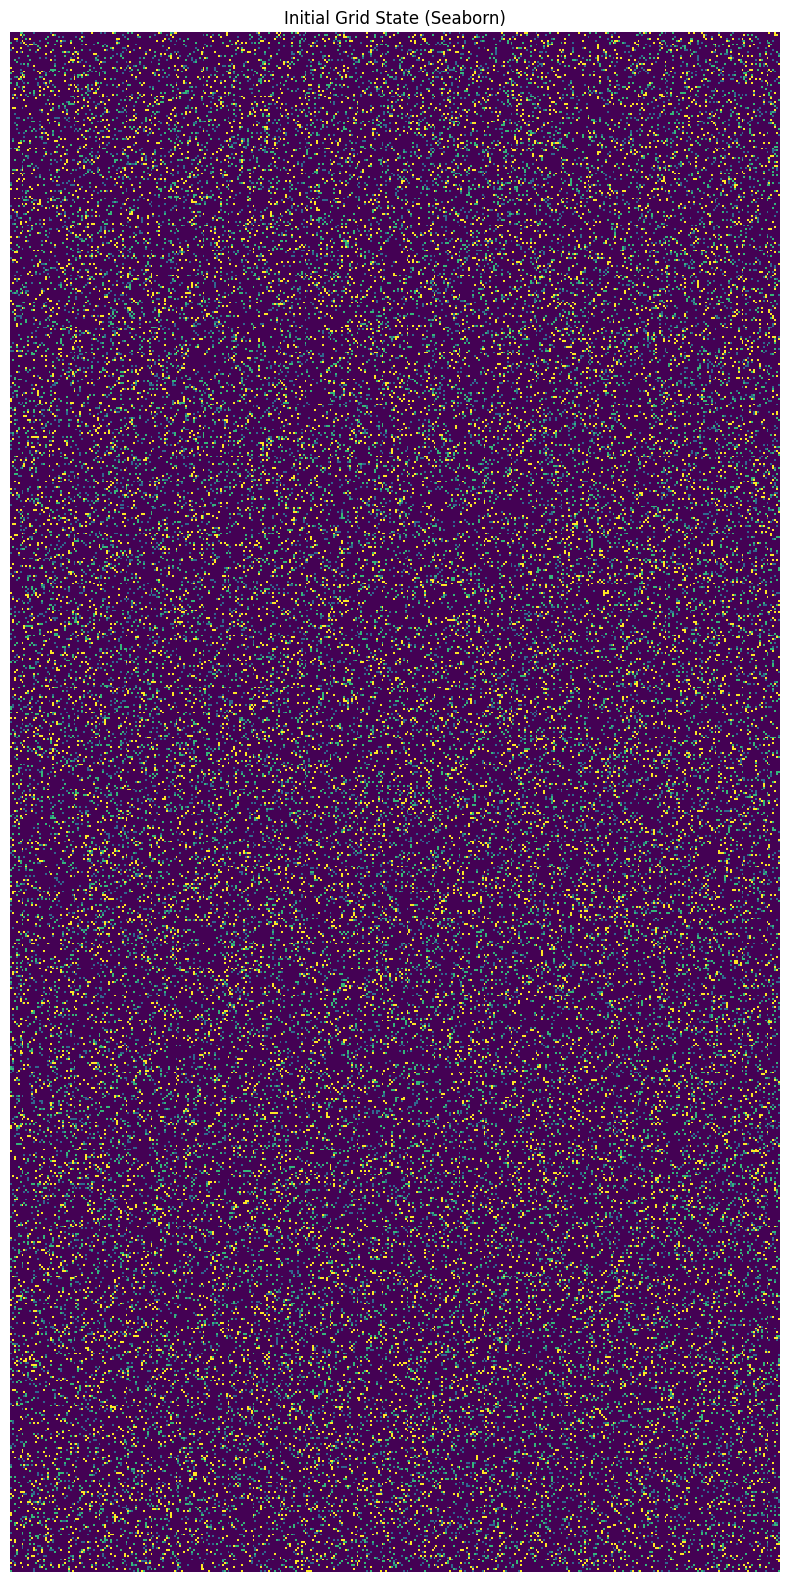

In [17]:
import matplotlib.pyplot as plt
# hashtag
# Create an instance of the game
game = RockPaperScissors()
game.seeding()

# Convert the CuPy grid to a NumPy array
numpy_grid = cp.asnumpy(game.grid)

# Use Seaborn to create a heatmap
plt.figure(figsize=(width/20, height/20)) # Adjust figure size based on grid dimensions
sns.heatmap(numpy_grid, cmap="viridis", cbar=False, square=True)
plt.title("Initial Grid State (Seaborn)")
plt.axis('off') # Hide axes
plt.show()

PyGame generating visualization through time

In [ ]:
# This code is intended to be run in a local Python environment with Pygame installed.
# It will not display a window in Google Colab.

import pygame
import pandas as pd
import numpy as np
import time # Import time for potential delays

# Assuming width and height are defined globally or passed in
# If running this code separately, make sure width and height are defined.
# Example:
# width = 800
# height = 400

# Define colors for the states (0: empty, 1: rock, 2: paper, 3: scissors)
BLACK = (0, 0, 0)       # Empty
RED = (255, 0, 0)       # Rock
GREEN = (0, 255, 0)     # Paper
BLUE = (0, 0, 255)      # Scissors

COLORS = {
    0: BLACK,
    1: RED,
    2: GREEN,
    3: BLUE
}

# Initialize Pygame
pygame.init()

# Set the dimensions of the window
screen_width = width
screen_height = height
screen = pygame.display.set_mode((screen_width, screen_height))

# Set the window title
pygame.display.set_caption("Rock Paper Scissors Simulation")

# Load the simulation log
try:
    # Read the CSV, assuming it's epoch, serialized_grid
    log_df = pd.read_csv('log.csv', header=None)
    # Convert the string representation of the numpy array back to a numpy array
    # This assumes the grid was saved as a string using str() or similar
    # A more robust way would be to save each grid as a separate .npy file
    simulation_log = []
    for index, row in log_df.iterrows():
        epoch = row[0]
        # Safely evaluate the string representation of the array
        # This might need adjustment based on how the grid was saved to string
        try:
            # Assuming the grid was saved as a simple string representation like [[...]]
            # This is a fragile way to load numpy arrays from a string.
            # A better approach is to save each grid as a separate file (e.g., .npy)
            grid_str = row[1].replace('[[', '[').replace(']]', ']').replace(' ', ',').replace('[,', '[').replace(',]',']')
            grid_np = np.array(eval(grid_str), dtype=np.int32)
            # Ensure the loaded grid has the correct shape
            if grid_np.shape != (width, height):
                 # If eval is not suitable, or shape is wrong, try a more basic parsing
                 # This is a fallback and might still be fragile
                 grid_values = [int(val) for val in row[1].replace('[','').replace(']','').split() if val.isdigit()]
                 grid_np = np.array(grid_values, dtype=np.int32).reshape((width, height))

            simulation_log.append((epoch, grid_np))
        except Exception as e:
            print(f"Error loading grid for epoch {epoch}: {e}")
            # Handle error, maybe skip this epoch or stop loading
            continue

except FileNotFoundError:
    print("Error: log.csv not found. Please run the simulation cell first.")
    simulation_log = [] # Empty log if file not found

# --- Drawing parameters ---
# Calculate cell size
cell_size_x = screen_width // width
cell_size_y = screen_height // height

# Main game loop
running = True
clock = pygame.time.Clock()
current_epoch_index = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    if simulation_log and current_epoch_index < len(simulation_log):
        epoch, current_grid = simulation_log[current_epoch_index]

        # Clear the screen
        screen.fill(BLACK)

        # Draw the grid
        for y in range(height):
            for x in range(width):
                state = current_grid[y, x]
                color = COLORS.get(state, BLACK) # Default to black if state is unknown
                pygame.draw.rect(screen, color, (x * cell_size_x, y * cell_size_y, cell_size_x, cell_size_y))

        # Update the display
        pygame.display.flip()

        # Move to the next epoch
        current_epoch_index += 1

        # Control playback speed
        clock.tick(fps) # Use the fps constant defined earlier

    elif simulation_log:
        # Stop or loop when simulation ends
        print("Simulation visualization finished.")
        running = False # Stop after the last frame

    else:
        # If log was empty or not loaded, exit
        running = False


# Quit Pygame
pygame.quit()